In [37]:
# Tutorial: https://towardsdatascience.com/identify-your-datas-distribution-d76062fc0802

In [38]:
import re
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm 
import seaborn as sns
import pylab as py 
warnings.filterwarnings('ignore')
%matplotlib inline

In [39]:
# data source https://www.kaggle.com/austinreese/craigslist-carstrucks-data
df = pd.read_csv('vehicles.csv')

In [40]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [41]:
df.shape

(426880, 26)

In [42]:
df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object

In [43]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [44]:
# To estimate the distribution of price and odometer, so we select useful columns
columns = ['id','price','year','manufacturer','odometer']
df = df[columns]

In [45]:
# cast year column to integer from float
df['year'] = df['year'].apply(lambda x: str(int(x)) if x > 0   else x)

In [46]:
df.head()

,id,price,year,manufacturer,odometer
0,7222695916,6000,NaN,NaN,NaN
1,7218891961,11900,NaN,NaN,NaN
2,7221797935,21000,NaN,NaN,NaN
3,7222270760,1500,NaN,NaN,NaN
4,7210384030,4900,NaN,NaN,NaN


In [47]:
df.describe()

,id,price,odometer
count,4.268800e+05,4.268800e+05,4.224800e+05
mean,7.311487e+09,7.519903e+04,9.804333e+04
std,4.473170e+06,1.218228e+07,2.138815e+05
min,7.207408e+09,0.000000e+00,0.000000e+00
25%,7.308143e+09,5.900000e+03,3.770400e+04
50%,7.312621e+09,1.395000e+04,8.554800e+04
75%,7.315254e+09,2.648575e+04,1.335425e+05
max,7.317101e+09,3.736929e+09,1.000000e+07


In [48]:
# find the total of missing numbers in each cols
# e.g price is not missing, 4400 odometer values are missing
df.isna().sum()

id                  0
price               0
year             1205
manufacturer    17646
odometer         4400
dtype: int64

<AxesSubplot:>

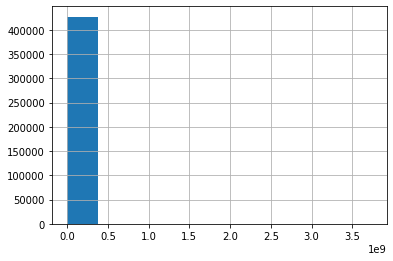

In [49]:
df['price'].hist()

In [50]:
CONF_LEV = 0.99 # confidence level
ALPHA = 1 - CONF_LEV # level of significance

def scale_data(column):
    """
    Take the <CONF_LEVEL * 100> % of the data and scale.
    Returns y, y_standardised and size of y
    """
    scaler = StandardScaler()
    y = df[column][df[column].notnull()].to_list() # drop the null values
    y.sort()

    len_y = len(y)

    # select the middle <CONF_LEVEL * 100> % of the data. assume normal distro.
    # assume a bell curve, select 99% of the middle data for 0.99 confidence level
    y = y[int(ALPHA * len_y):int(CONF_LEV * len_y)]

    len_y = len(y)
    yy=([[x] for x in y])

    # scaler.fit(yy) # Compute the mean and std to be used for later scaling.
    # y_std = scaler.transform(yy) # Perform standardization by centering and scaling.
    # OR
    y_std = scaler.fit_transform(yy) # Perform the two steps above as one.

    y_std = y_std.flatten()

    return y, y_std, len_y


In [64]:
NUMBER_OF_BINS = 11

def fit_distribution(standardised_data):
    y_std, size = standardised_data, len(standardised_data)
    # Set up list of candidate distributions to use
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more

    dist_names = [
        'weibull_min','norm','weibull_max','beta', 'invgauss','uniform',
        'gamma','expon', 'lognorm','pearson3','triang'
    ]

    # continuos_distro = [
    #     d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)
    # ] # all available continous distributions in scipy

    # discrete_distro = [
    #     d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_discrete)
    # ] # all available discrete distributions in scipy

    chi_square_statistics = []
    # 11 bins
    percentile_bins = np.linspace(0, 100, NUMBER_OF_BINS)
    percentile_cutoffs = np.percentile(y_std, percentile_bins) # categorise y_std into 11 bins
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions
    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(stats, distribution)
        param = dist.fit(y_std)
        print("{}\n{}\n".format(distribution, param))

        # Get expected counts in percentile bins
        # cdf of fitted distribution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        # A chi-square (χ2) statistic is a test that measures how expectations
        # compare to actual observed data (or model results). The data used in
        # calculating a chi-square statistic must be random, raw,
        # mutually exclusive, drawn from independent variables, and drawn from a
        # large enough sample.
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency),0)
        chi_square_statistics.append(ss)


    # Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)


    print ('\nDistributions listed by Betterment of fit:')
    print ('............................................')
    print (results)

In [65]:
y, y_std, size = scale_data('price')
# select the minimum chisquare values
fit_distribution(y_std)

weibull_min
(0.3562420727425598, -1.2309655655757914, 1.0454260046806056)

norm
(7.228685273555399e-17, 1.0000000000000002)

weibull_max
(59533308.25920732, 44675160.12848368, 44675160.58339321)

beta
(0.2388065831255009, 1.1637717506536793, -1.2309655655757914, 4.875420610758933)

invgauss
(0.4378971820264218, -1.7139769095439341, 3.914109314358006)

uniform
(-1.2309655655757912, 4.8702757683572795)

gamma
(0.28615908876435625, -1.2309655655757914, 2.4666839140894092)

expon
(-1.2309655655757912, 1.2309655655757912)

lognorm
(0.650400860729848, -1.6419230132341776, 1.3486149895274293)

pearson3
(3.0863364170339063, -1.0194012239829828e-16, 1.899586926575652)

triang
(1.0669949724732894e-05, -1.2310179519947297, 4.9022556554729775)


Distributions listed by Betterment of fit:
............................................
   Distribution  chi_square
7         expon     22953.0
4      invgauss     33710.0
8       lognorm     36794.0
2   weibull_max     88816.0
10       triang    111466.0


Text(0, 0.5, 'Frequency')

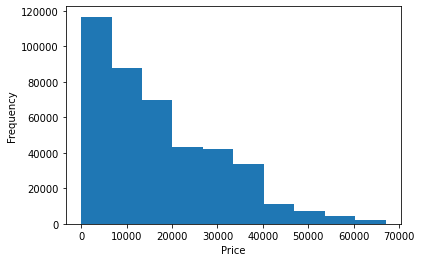

In [66]:
plt.hist(y)
plt.xlabel('Price')
plt.ylabel('Frequency')

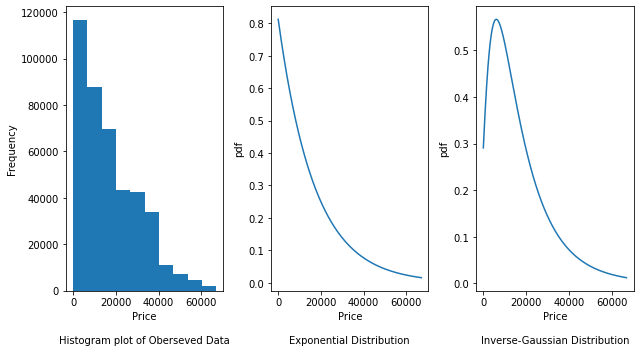

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y)
axes[0].set_xlabel('Price\n\nHistogram plot of Oberseved Data')
axes[0].set_ylabel('Frequency')

# expon.pdf(x, loc, scale) is identically equivalent to
# expon.pdf(y) / scale with y = (x - loc) / scale
# loc = location or shift. scale = scale. These values are printed in params
# of 2 lines above
expon_loc, expon_scale = (-1.2309655655757912, 1.2309655655757912)
axes[1].plot(y, stats.expon.pdf(y_std, expon_loc, expon_scale))
axes[1].set_xlabel('Price\n\nExponential Distribution')
axes[1].set_ylabel('pdf')

# invgauss.pdf(x, mu, loc, scale) is identically equivalent to
# invgauss.pdf(y, mu) / scale with y = (x - loc) / scale.
invg_mu, invg_loc, invg_scale = (0.4378971820264218, -1.7139769095439341, 3.914109314358006)
axes[2].plot(y, stats.invgauss.pdf(y_std, invg_mu, invg_loc, invg_scale))
axes[2].set_xlabel('Price\n\nInverse-Gaussian Distribution')
axes[2].set_ylabel('pdf')
fig.tight_layout()

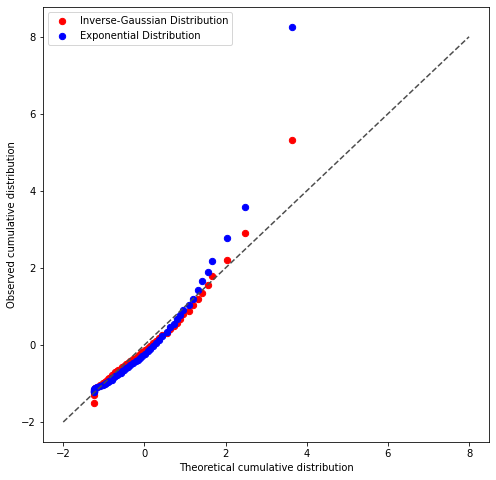

In [72]:
# QQ plots is a graphical method for comparing two probability distributions by
# plotting their quantiles against each other.

# Let’s analyse the QQ plot to choose between exponential or inverse gaussian distributions

random_expon_data_points = stats.expon.rvs(expon_loc, expon_scale, size=2000)
random_invgauss_data_points = stats.invgauss.rvs(invg_mu, invg_loc, invg_scale, size = 2000)
f, ax = plt.subplots(figsize=(8,8))
QQ_INTERVAL = [-2, 8] # y_std.min(), y_std.max() is contained in INTERVAL
ax.plot(QQ_INTERVAL, QQ_INTERVAL, ls="--", c=".3")

NUM_BINS = 51
percentile_bins = np.linspace(0, 100, NUM_BINS)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)

percentile_cutoffs_expon= np.percentile(random_expon_data_points, percentile_bins)
percentile_cutoffs_invgauss = np.percentile(random_invgauss_data_points, percentile_bins)


ax.scatter(
    percentile_cutoffs1, percentile_cutoffs_invgauss, c = 'r',
    label = 'Inverse-Gaussian Distribution', s = 40
)
ax.scatter(
    percentile_cutoffs1, percentile_cutoffs_expon, c = 'b',
    label = 'Exponential Distribution', s = 40
)

ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()

# Both the distributions do fairly well. Exponential is slightly better than
# Inverse Gaussian in approximating ‘Price’ Data.

## for odometer

In [73]:
y_odo, y_odo_std, size = scale_data('odometer')
# select the minimum chisquare values
fit_distribution(y_odo_std)

weibull_min
(0.9881590543515774, -1.5052557047139992, 1.2612236632997722)

norm
(8.786730479340225e-17, 1.0000000000000002)

weibull_max
(15.564797115081905, 12.703169931798694, 13.14897267304433)

beta
(1.099464491343034, 2.384685330116807, -1.5076405277154736, 4.71789097240473)

invgauss
(0.1604872640676844, -2.656019589795715, 16.549721731203284)

uniform
(-1.505255704713999, 4.654284245312688)

gamma
(2.1602464413814886, -1.6404216094967126, 0.7593684106630003)

expon
(-1.505255704713999, 1.505255704713999)

lognorm
(0.3712757831517502, -2.7593946384559125, 2.580036187780177)

pearson3
(1.3607565399956363, 4.854448532290203e-17, 1.1160970599835187)

triang
(3.571582770557333e-05, -1.5054220742218116, 4.658138989747099)


Distributions listed by Betterment of fit:
............................................
   Distribution  chi_square
3          beta      3200.0
10       triang      3287.0
6         gamma     13312.0
9      pearson3     13313.0
4      invgauss     24064.0
8       l

Text(0, 0.5, 'Frequency')

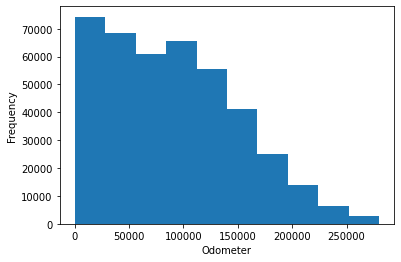

In [74]:
plt.hist(y_odo)
plt.xlabel('Odometer')
plt.ylabel('Frequency')

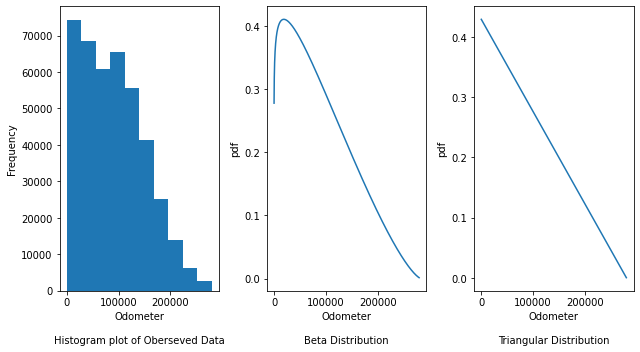

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y_odo)
axes[0].set_xlabel('Odometer\n\nHistogram plot of Oberseved Data')
axes[0].set_ylabel('Frequency')

# beta.pdf(x, a, b, loc, scale) is identically equivalent to
# beta.pdf(y, a, b) / scale with y = (x - loc) / scale.
betaa, betab, betaloc, betascale = (1.099464491343034, 2.384685330116807, -1.5076405277154736, 4.71789097240473)
axes[1].plot(y_odo, stats.beta.pdf(y_odo_std, betaa, betab, betaloc, betascale))
axes[1].set_xlabel('Odometer\n\nBeta Distribution')
axes[1].set_ylabel('pdf')

# triang.pdf(x, c, loc, scale) is identically equivalent to
# triang.pdf(y, c) / scale with y = (x - loc) / scale.
triangc, triangloc, triangscale = (3.571582770557333e-05, -1.5054220742218116, 4.658138989747099)
axes[2].plot(y_odo, stats.triang.pdf(y_odo_std, triangc, triangloc, triangscale))
axes[2].set_xlabel('Odometer\n\nTriangular Distribution')
axes[2].set_ylabel('pdf')
fig.tight_layout()

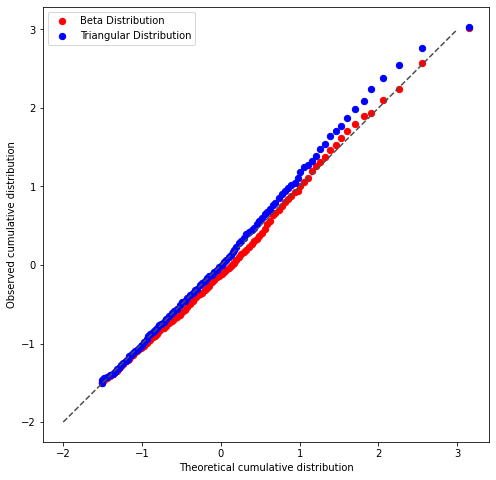

In [78]:
# QQ plots is a graphical method for comparing two probability distributions by
# plotting their quantiles against each other.

# Let’s analyse the QQ plot to choose between exponential or inverse gaussian distributions

random_beta_data_points = stats.beta.rvs(betaa, betab, betaloc, betascale, size=1000)
random_triang_data_points = stats.triang.rvs(triangc, triangloc, triangscale, size = 1000)
f, ax = plt.subplots(figsize=(8,8))
QQ_INTERVAL = [-2, 3] # y_odo_std.min(), y_odo_std.max() is contained in INTERVAL
ax.plot(QQ_INTERVAL, QQ_INTERVAL, ls="--", c=".3")

NUM_BINS = 101
percentile_bins = np.linspace(0, 100, NUM_BINS)
percentile_cutoffs_odo = np.percentile(y_odo_std, percentile_bins)

percentile_cutoffs_beta = np.percentile(random_beta_data_points, percentile_bins)
percentile_cutoffs_triang = np.percentile(random_triang_data_points, percentile_bins)


ax.scatter(
    percentile_cutoffs_odo, percentile_cutoffs_beta, c = 'r',
    label = 'Beta Distribution', s = 40
)
ax.scatter(
    percentile_cutoffs_odo, percentile_cutoffs_triang, c = 'b',
    label = 'Triangular Distribution', s = 40
)

ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()

# Both the distributions do fairly well. Beta is slightly better than
# Traingular in approximating ‘Odometer’ Data.